<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линенейная-регрессия" data-toc-modified-id="Линенейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линенейная регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import warnings
warnings.simplefilter("ignore")

Откроем датасет и сразу сделаем ресемплирование по часу:

In [6]:
df =  pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод** 

Ресеплирование произведено далее приступим к анализу данных.

## Анализ

Далее посмотрим сезонность, тренд и остаток декомпозиции.

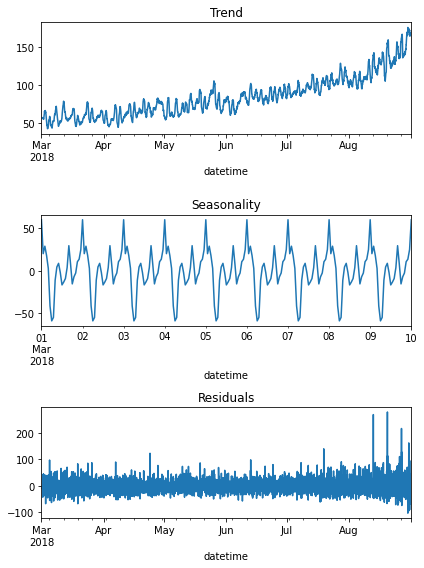

In [3]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-10 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Сезонность присутствует, в течении дня количество заказов меняется в зависимости от часа. Остаток декомпозиции однороден, есть несколько выбросов в конце, но они не существенны. А тренд показывает явный рост, поэтому необходимо добавить для обучения стационарный ряд(скользящее среднее), так же несколько рядов с лагом, для этого напишем функцию, которая также добавит в датасет час, остальные параметры не нужны, так как сезонность показала только зависимость от времени дня. Максимальный лаг зададим в соответствии с количеством часов в дне, а среднее будет равно половине этого числа то есть 24 и 12 соответственно. 

In [4]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
make_features(df, 24, 12)  
df

,num_orders,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,163.416667
2018-08-31 20:00:00,154,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,170.916667
2018-08-31 21:00:00,159,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.583333


Далее разделим датасет на выборки:

In [5]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

**Вывод**

В результате анализа были добавлены новые признаки со стационаным рядом, отстающими значениями, часами.

## Обучение

Приступим к обучению моделей, выберем 3 модели и подберем к ним параметры:

### Линенейная регрессия

In [12]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train) 

LinearRegression()

### Catboost

In [8]:
def rmse(target, predict): # функция RMSE
    target = np.array(target)
    predict = np.array(predict)
    return np.sqrt(((predictions - targets) ** 2).mean())
rmse_s = make_scorer(rmse, greater_is_better=False) # скорер RMSE
cat_features = ['hour'] # категориальные признаки

Подберем параметры, параметр n_splits определим равным количеству месяцев, то есть 6.

In [14]:
parametrs = {'n_estimators': range (10, 100, 10),
              'max_depth': range (1,30, 2)            
}
catboost = CatBoostRegressor(random_state = 12345, cat_features = cat_features)
tscv = TimeSeriesSplit(n_splits=6)
grid_cb = GridSearchCV(catboost, parametrs, cv=tscv, n_jobs=-1, scoring = rmse_s)
grid_cb.fit(features_train, target_train)
grid_cb.best_params_

Learning rate set to 0.5
0:	learn: 27.2193899	total: 766us	remaining: 6.89ms
1:	learn: 24.1037451	total: 1.4ms	remaining: 5.6ms
2:	learn: 22.9558226	total: 2.06ms	remaining: 4.8ms
3:	learn: 22.0008645	total: 2.63ms	remaining: 3.95ms
4:	learn: 21.2955744	total: 3.29ms	remaining: 3.29ms
5:	learn: 20.7899363	total: 3.82ms	remaining: 2.55ms
6:	learn: 20.5643463	total: 4.45ms	remaining: 1.91ms
7:	learn: 19.9557638	total: 5.05ms	remaining: 1.26ms
8:	learn: 19.7401047	total: 5.7ms	remaining: 633us
9:	learn: 19.4751320	total: 6.37ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.1955718	total: 994us	remaining: 8.95ms
1:	learn: 24.3560606	total: 2.02ms	remaining: 8.08ms
2:	learn: 23.1792174	total: 2.86ms	remaining: 6.67ms
3:	learn: 22.6950019	total: 3.7ms	remaining: 5.56ms
4:	learn: 21.4001751	total: 4.6ms	remaining: 4.6ms
5:	learn: 21.0271001	total: 5.39ms	remaining: 3.59ms
6:	learn: 20.6122922	total: 6.24ms	remaining: 2.67ms
7:	learn: 20.4898691	total: 7.13ms	remaining: 1.78ms
8:	learn:

{'max_depth': 1, 'n_estimators': 10}

In [13]:
catboost = CatBoostRegressor(random_state = 12345, cat_features = cat_features, loss_function = 'RMSE', iterations = 260)
catboost.fit(features_train, target_train, verbose = 100)

Learning rate set to 0.152079
0:	learn: 36.0725340	total: 57.2ms	remaining: 14.8s
100:	learn: 18.4130623	total: 737ms	remaining: 1.16s
200:	learn: 15.0926770	total: 1.47s	remaining: 432ms
259:	learn: 13.6149640	total: 1.91s	remaining: 0us


### LightGBM

In [6]:
features_train[['hour']] = features_train[['hour']].astype('category')
features_test[['hour']] = features_test[['hour']].astype('category')

In [9]:
parametrs = {'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2)            
}
LGBM = LGBMRegressor(random_state = 12345)
tscv = TimeSeriesSplit(n_splits=6)
grid_lgbm = GridSearchCV(LGBM, parametrs, cv=tscv, n_jobs=-1, scoring=rmse_s)
grid_lgbm.fit(features_train, target_train)
grid_lgbm.best_params_

{'max_depth': 1, 'n_estimators': 10}

In [10]:

model_lgbm = LGBMRegressor(random_state = 12345, max_depth = 1, n_estimators =10, metrics = 'rmse_s')
model_lgbm.fit(features_train, target_train)

LGBMRegressor(max_depth=1, metrics='rmse_s', n_estimators=10,
              random_state=12345)

## Тестирование

Теперь сделаем предсказания на основе тестовой выборки с помощью каждой модели и выберем лучшую:

### Линейная регрессия

rmse = 45.20944297134872


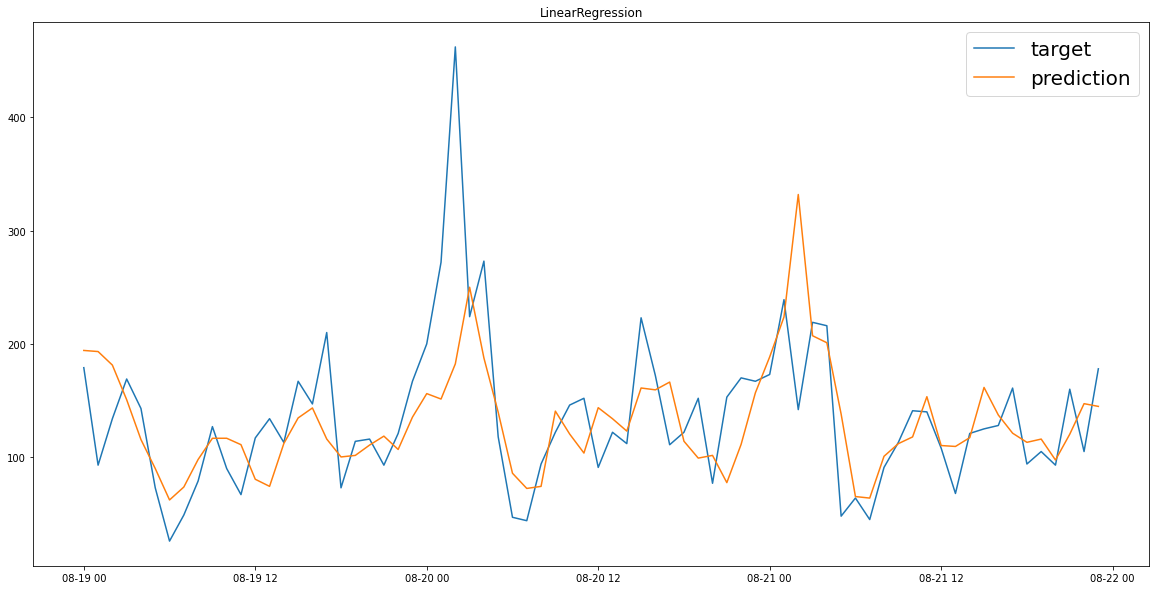

In [14]:
predictions_test_lr = model_lr.predict(features_test) 
result_lr = mean_squared_error(target_test, predictions_test_lr, squared=False)
print('rmse =', result_lr)
predictions = target_test.reset_index()
predictions['num_orders'] = pd.Series(predictions_test_lr)
predictions = predictions.set_index(['datetime'])
plt.figure(figsize=(20, 10))
plt.title('LinearRegression')
plt.plot(target_test['2018-08-19':'2018-08-21'])
plt.plot(predictions['2018-08-19':'2018-08-21'])
plt.legend(['target', 'prediction'], fontsize=20)
plt.show()

### Catboost

rmse = 40.60413370805449


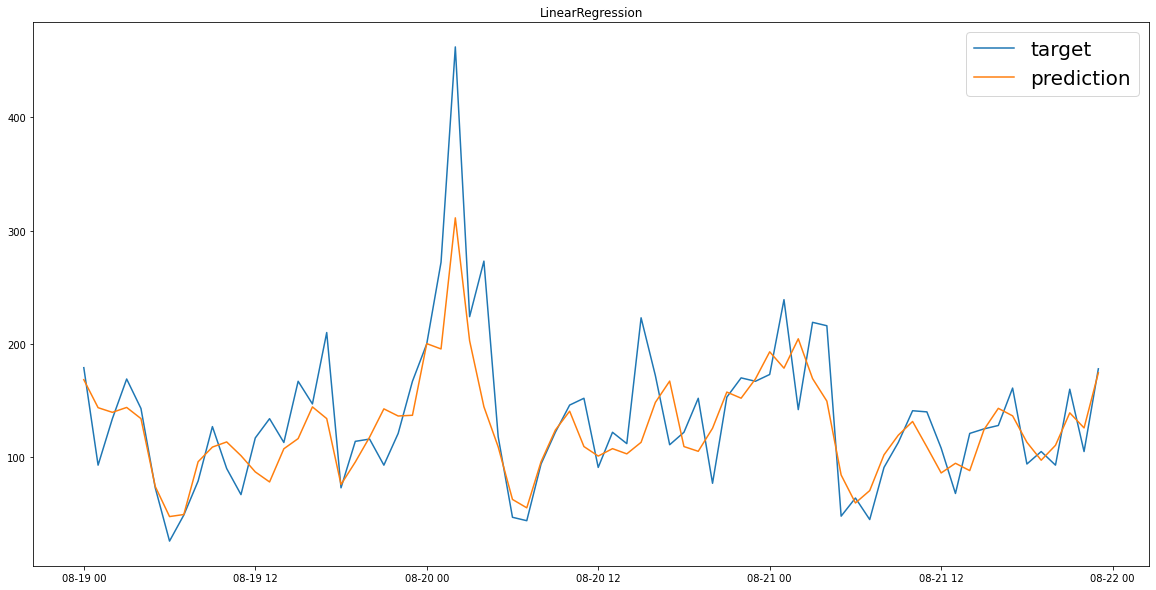

In [15]:
predictions_test_cb = catboost.predict(features_test) 
result_cb = mean_squared_error(target_test, predictions_test_cb)**0.5
print('rmse =', result_cb)
predictions = target_test.reset_index()
predictions['num_orders'] = pd.Series(predictions_test_cb)
predictions = predictions.set_index(['datetime'])
plt.figure(figsize=(20, 10))
plt.title('LinearRegression')
plt.plot(target_test['2018-08-19':'2018-08-21'])
plt.plot(predictions['2018-08-19':'2018-08-21'])
plt.legend(['target', 'prediction'], fontsize=20)
plt.show()

### LightGBM

rmse = 75.21840935350939


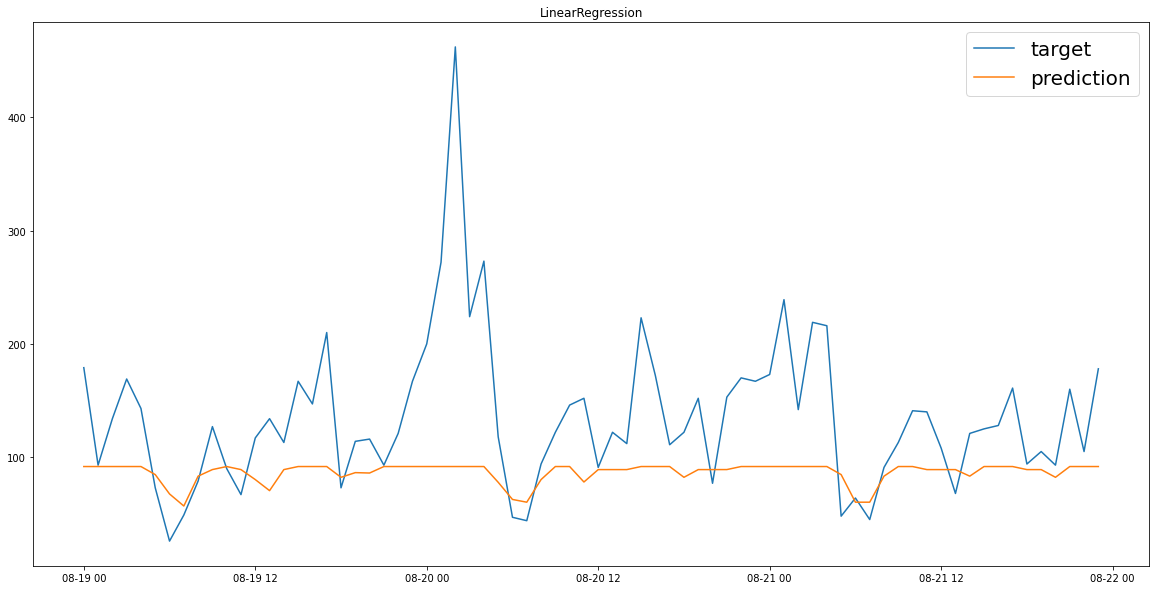

In [16]:
predictions_test_lgbm = model_lgbm.predict(features_test) 
result_lgbm = mean_squared_error(target_test, predictions_test_lgbm)**0.5
print('rmse =', result_lgbm)
predictions = target_test.reset_index()
predictions['num_orders'] = pd.Series(predictions_test_lgbm)
predictions = predictions.set_index(['datetime'])
plt.figure(figsize=(20, 10))
plt.title('LinearRegression')
plt.plot(target_test['2018-08-19':'2018-08-21'])
plt.plot(predictions['2018-08-19':'2018-08-21'])
plt.legend(['target', 'prediction'], fontsize=20)
plt.show()

**Вывод** 

Лучший показатель RMSE равный 40.60413370805449 показала модель Catboost, следующей идет Линейная регрессия 45.20944297134872, а LightGBM 75.21840935350939. По графикам видно, что значения Catboost и Линейной регрессии ближе к таргету, а значения предсказанные LightGBM далеки от реальных и скорее походят на скользящее среднее. Период для графиков подобран в соотвтетствии с тем где визуально было больше отклонений для лучшей модели Catboost. Порог в 48 RMSE был преодален, итоговый показатель был ниже того что обозначено в задании в несколько раз.